In [1]:
import saspy
saspy.__version__

'3.1.8'

In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 22:11:17) \n[GCC 7.3.0]'

In [3]:
import pandas as pd
from IPython.display import HTML

In [4]:
sas = saspy.SASsession(cfgname='iomlinux')

Please enter the IOM user id: sagang
Please enter the password for IOM user : ········
SAS Connection established. Subprocess id is 6249



In [5]:
sas

Access Method         = IOM
SAS Config name       = iomlinux
SAS Config file       = /opt/anaconda3/lib/python3.7/site-packages/saspy/sascfg_personal.py
WORK Path             = /opt/scratch/saswork/SAS_work683700003CEF_ccbu-sas94.aws.sas.com/SAS_work764A00003CEF_ccbu-sas94.aws.sas.com/
SAS Version           = 9.04.01M5P09132017
SASPy Version         = 3.1.8
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = latin1
Python Encoding value = latin1
SAS process Pid value = 15599


In [6]:
 %%SAS
 proc corr data = sashelp.cars;
 var MSRP Invoice EngineSize Cylinders Horsepower MPG_City MPG_Highway Weight Wheelbase Length;
 run;

Using SAS Config named: iomlinux
Please enter the IOM user id: sagang
Please enter the password for IOM user : ········
SAS Connection established. Subprocess id is 6341



To Submit SAS Code Directly from Python


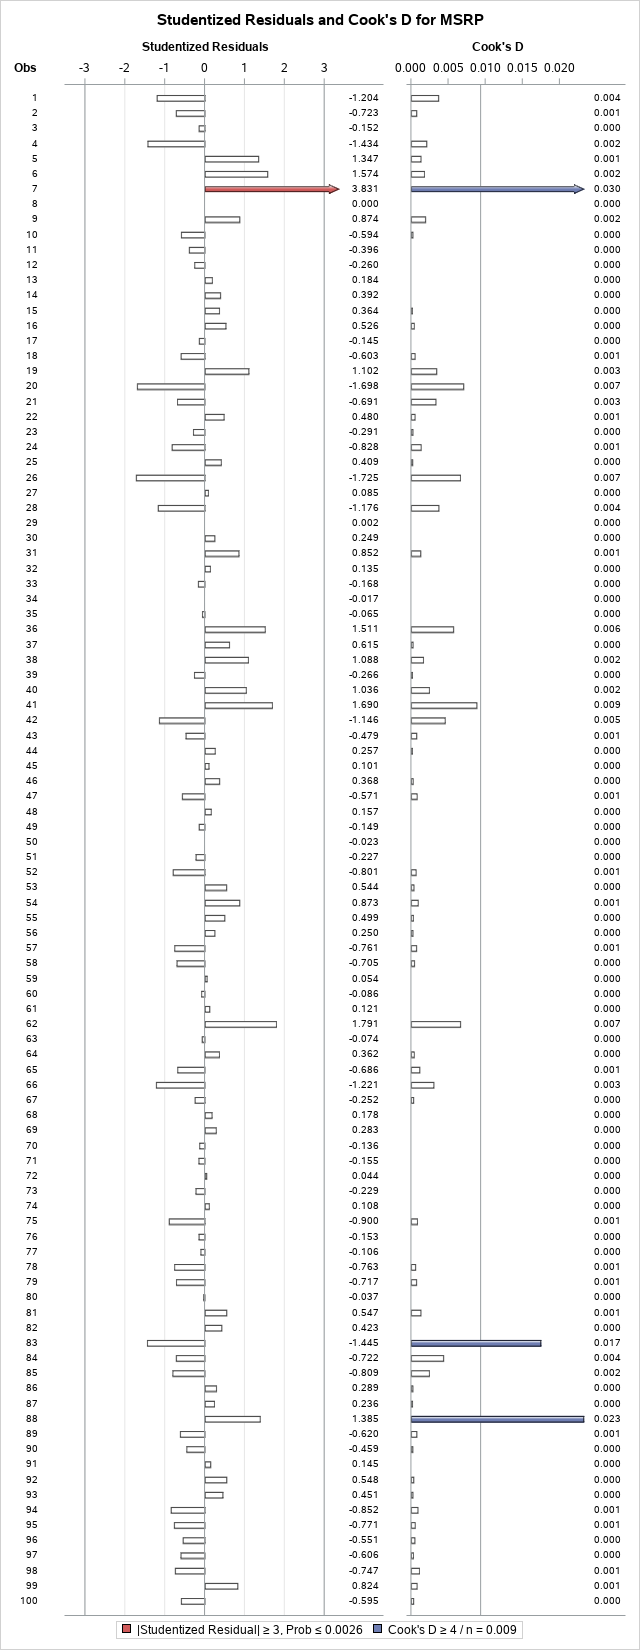
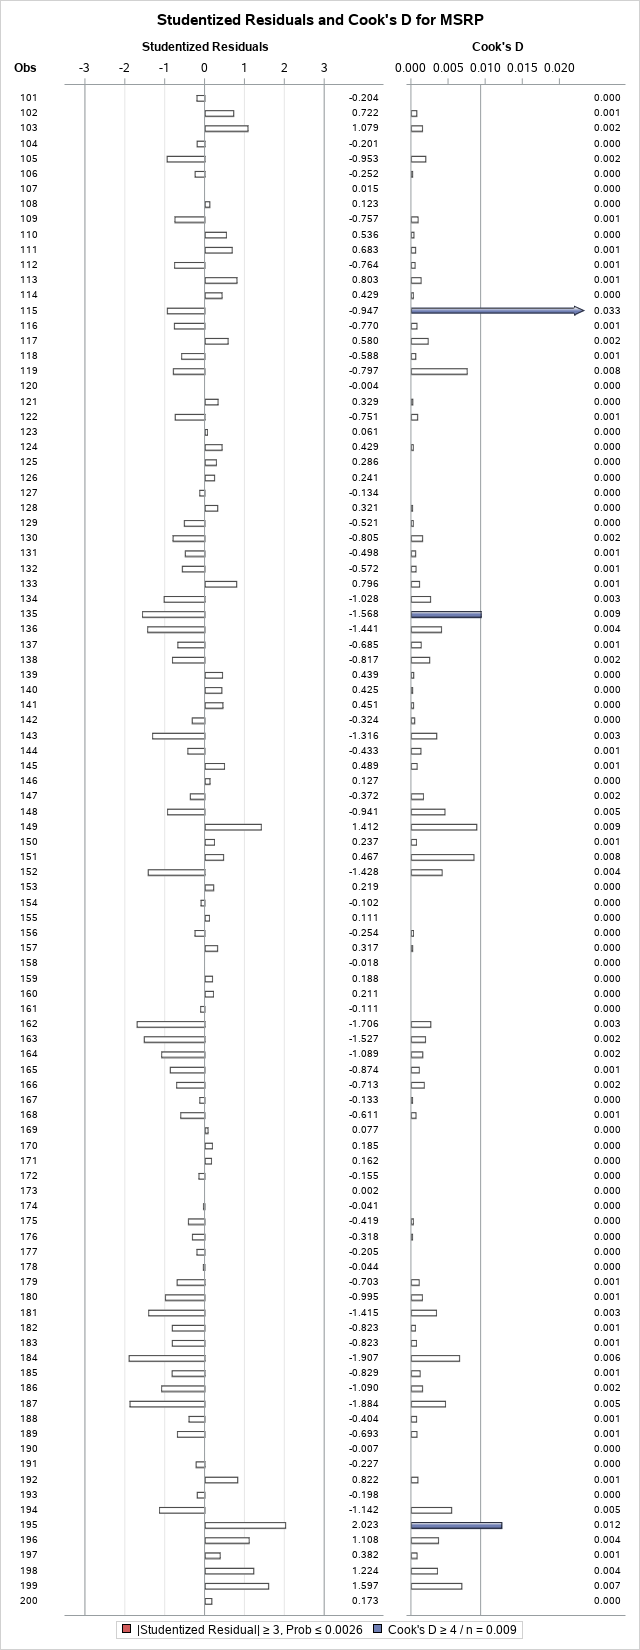
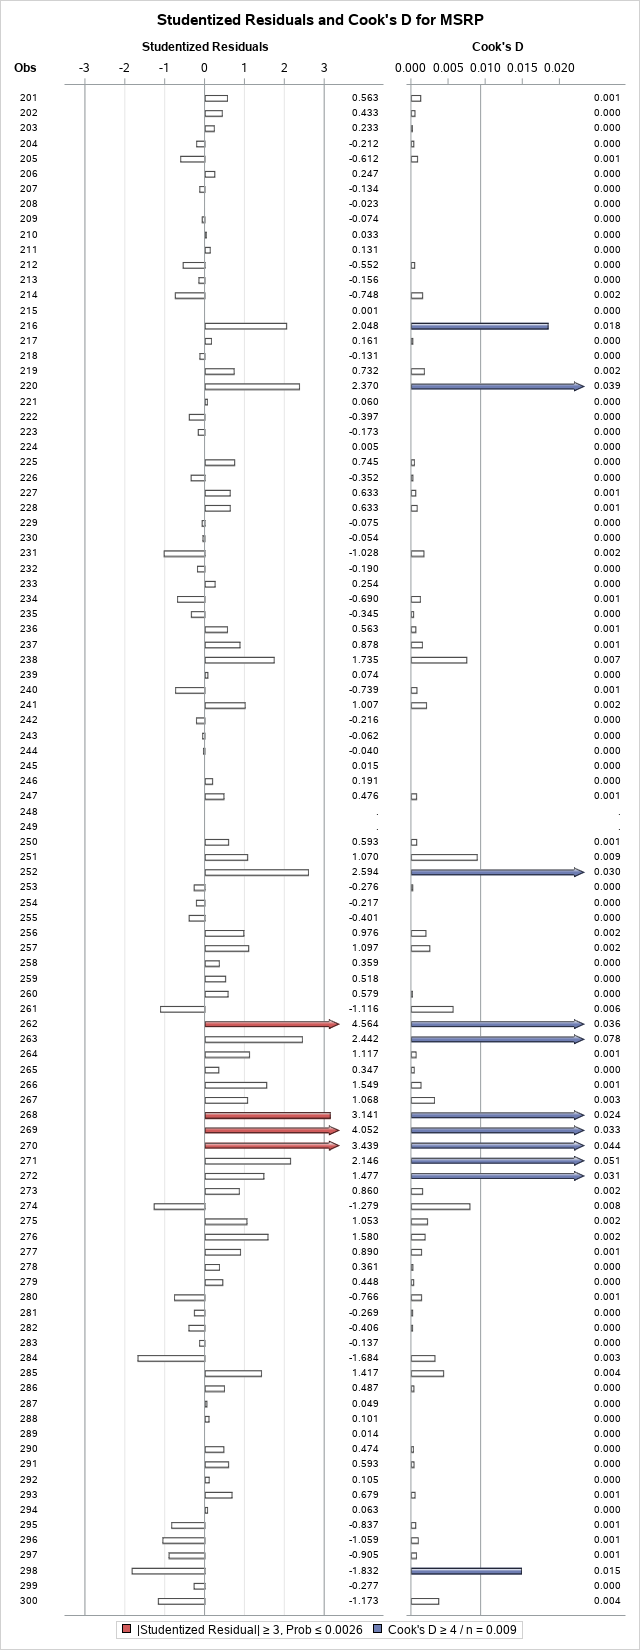
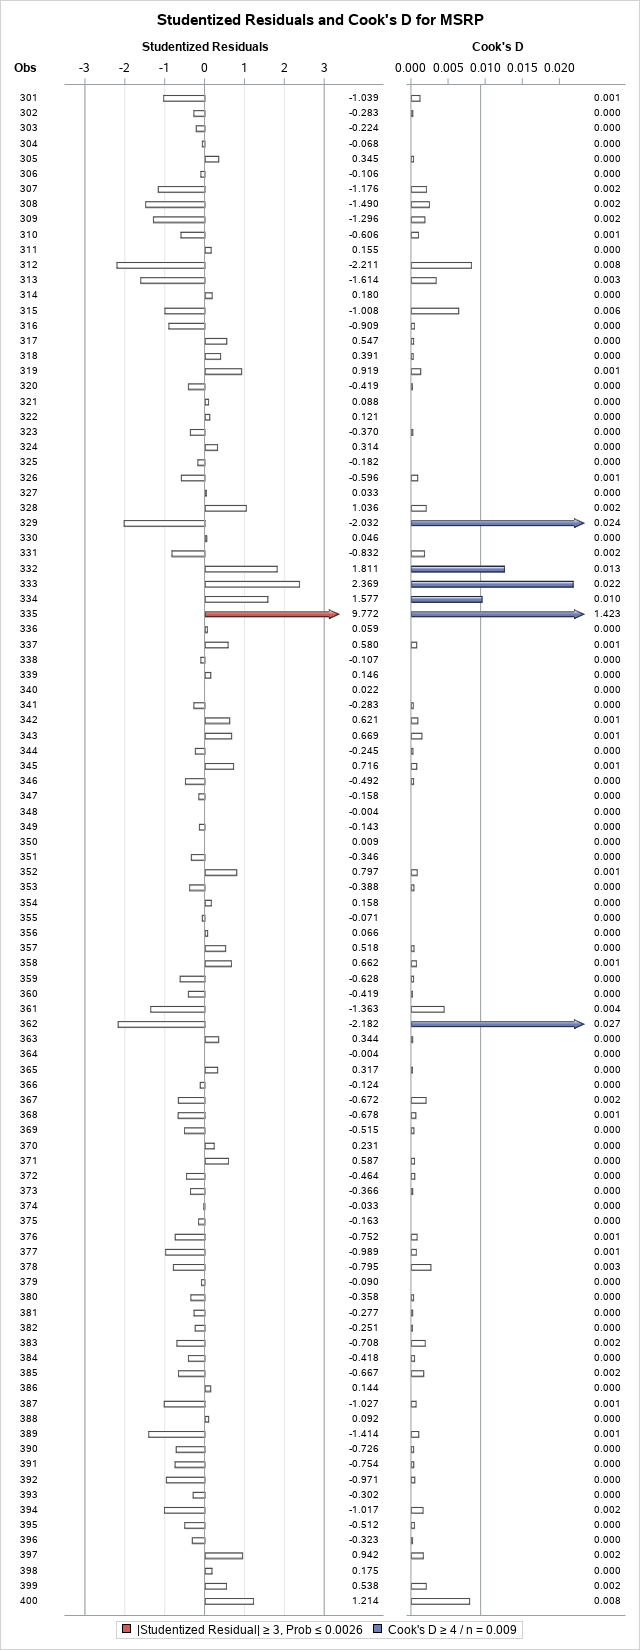
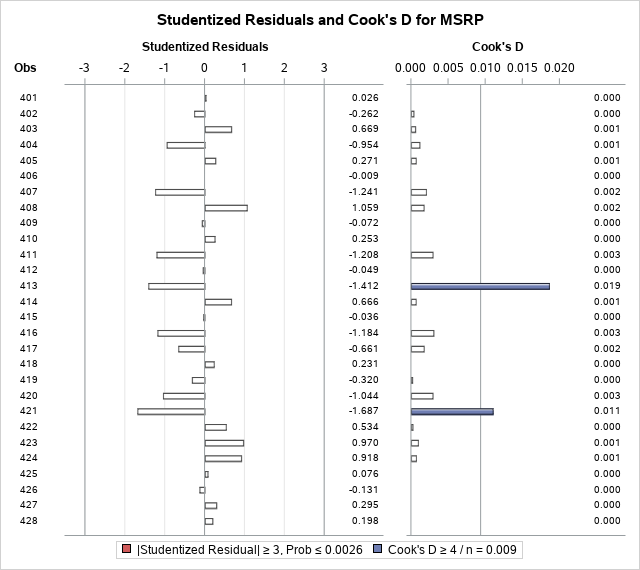
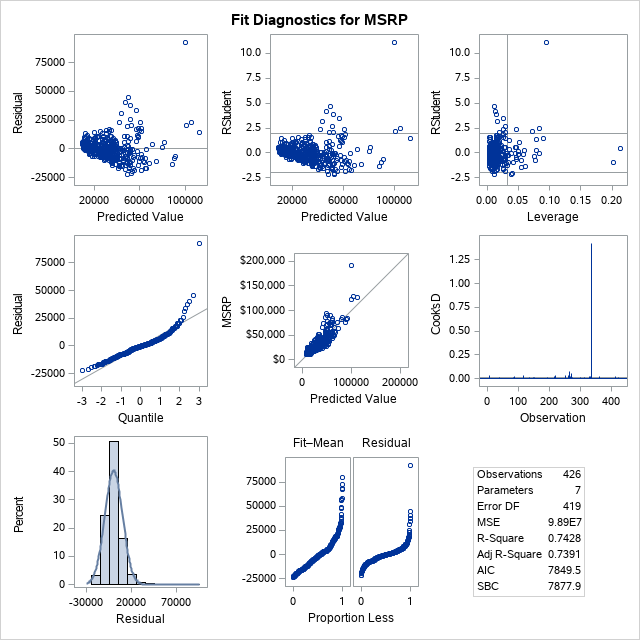
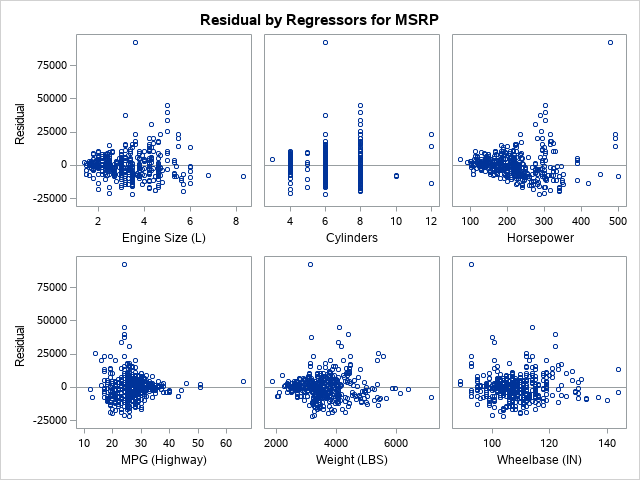

In [8]:
reg_result=sas.submit("""proc reg data = sashelp.cars plots=diagnostics(stats=(default aic sbc));
model MSRP = EngineSize Cylinders Horsepower MPG_City MPG_Highway Weight Wheelbase Length / selection=stepwise
run;""")
HTML(reg_result['LST'])

In [9]:
sas.saslib('sagang',"'/eec_retail/users/sagang/Data'")

5                                                          The SAS System                            00:14 Tuesday, December 3, 2019

40         
41         libname sagang '/eec_retail/users/sagang/Data'  ;
NOTE: Libref SAGANG refers to the same physical library as SATHISH.
NOTE: Libref SAGANG was successfully assigned as follows: 
      Engine:        V9 
      Physical Name: /eec_retail/users/sagang/Data
42         
43         


In [10]:
sas.datasets('sagang')

6                                                          The SAS System                            00:14 Tuesday, December 3, 2019

46         

ERROR: Cannot write image to /opt/sas/config/Lev2/SASApp/StudResCooksDChart.png. Please ensure that proper disk permissions are set.
ERROR: Cannot write image to /opt/sas/config/Lev2/SASApp/StudResCooksDChart.png. Please ensure that proper disk permissions are set.
NOTE: The SAS System stopped processing this step because of errors.
NOTE: The PROCEDURE REG printed pages 1-2.
NOTE: PROCEDURE REG used (Total process time):
      real time           37.27 seconds
      cpu time            0.08 seconds
      


47         proc datasets dd=sagang;
                                                             Directory

                                          Libref             SAGANG                       
                                          Engine             V9                           
                                          Physica

Check out the data in SAS

In [11]:
airline_sas = sas.sasdata('AIR', libref="sagang")
airline_sas.tail()

,DATE,AIR
0,1960-08-01,606
1,1960-09-01,508
2,1960-10-01,461
3,1960-11-01,390
4,1960-12-01,432


In [12]:
# 6mths ahead
forecast_job= sas.submit(
    """proc esm data=sagang.AIR out=work.AIRLINE_fcst lead=6; 
      id DATE interval=month;
      forecast AIR;
      run;"""
)
airline_forecast_sas = sas.sasdata('AIRLINE_fcst', libref="WORK")
airline_forecast_sas.tail(10)

,DATE,AIR
0,1960-09-01,508.000000
1,1960-10-01,461.000000
2,1960-11-01,390.000000
3,1960-12-01,432.000000
4,1961-01-01,431.958071
5,1961-02-01,431.958071
6,1961-03-01,431.958071
7,1961-04-01,431.958071
8,1961-05-01,431.958071
9,1961-06-01,431.958071


In [13]:
# Move the data to a datafranme and use as needed
airline_df = sas.sasdata2dataframe('AIR',libref="sagang")
airline_df.head()

,DATE,AIR
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [14]:
airline_df = airline_df.set_index('DATE')

airline_df.index.freq = 'MS' # set Index frequency cal month begin

airline_df.head()

,AIR
DATE,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


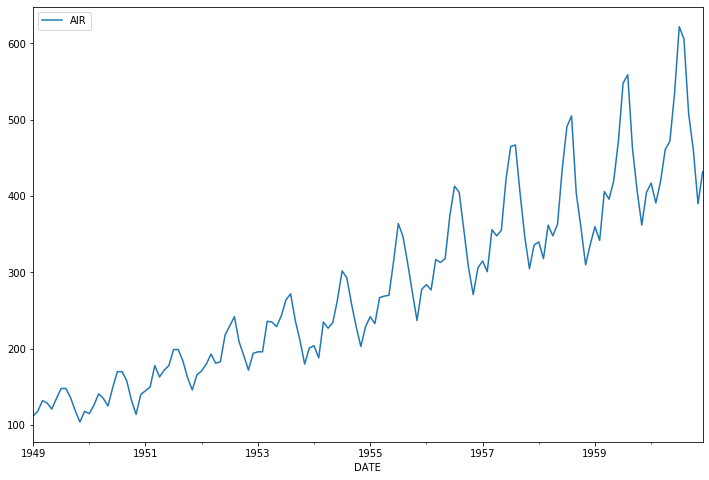

In [15]:
airline_df.plot(figsize=(12,8));

In [16]:
print(f"There are a total of {len(airline_df)} values in the dataset, we can split this to test and train") 
train_len = len(airline_df)-12
train = airline_df.iloc[:train_len]
test = airline_df.iloc[train_len:]
print(f"Post Split Training Data has the first {len(train)} values in the dataset, while the rest is in holdout")

There are a total of 144 values in the dataset, we can split this to test and train
Post Split Training Data has the first 132 values in the dataset, while the rest is in holdout


In [17]:
train.head()

,AIR
DATE,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Scale the Data before Fitting the Model

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit model
model.fit_generator(generator,epochs=10)

Epoch 1/10
120/120 [==============================] - 5s 41ms/step - loss: 0.0308
Epoch 2/10
120/120 [==============================] - 5s 42ms/step - loss: 0.0158
Epoch 3/10
120/120 [==============================] - 5s 40ms/step - loss: 0.0127
Epoch 4/10
120/120 [==============================] - 5s 40ms/step - loss: 0.0116
Epoch 5/10
120/120 [==============================] - 5s 38ms/step - loss: 0.0091
Epoch 6/10
120/120 [==============================] - 5s 41ms/step - loss: 0.0087
Epoch 7/10
120/120 [==============================] - 5s 40ms/step - loss: 0.0078
Epoch 8/10
120/120 [==============================] - 5s 38ms/step - loss: 0.0092
Epoch 9/10
120/120 [==============================] - 5s 39ms/step - loss: 0.0043
Epoch 10/10
120/120 [==============================] - 5s 44ms/step - loss: 0.0064


In [23]:
model.history.history.keys()

dict_keys(['loss'])

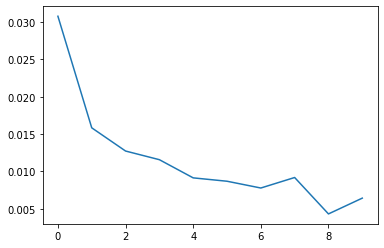

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
holdout_eval_batch1 = scaled_train[-12:]
holdout_eval_batch1

array([[0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

In [26]:
test_predictions = []

holdout_eval_batch1 = scaled_train[-n_input:]
current_batch = holdout_eval_batch1.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [27]:
keras_forecast = scaler.inverse_transform(test_predictions)

In [28]:
keras_forecast

array([[411.55800515],
       [424.54932594],
       [441.85670429],
       [455.39680058],
       [480.12275034],
       [516.20131516],
       [543.56342131],
       [528.85444814],
       [489.91378927],
       [464.43002218],
       [459.18252432],
       [467.14564049]])

In [29]:
test['os_pred'] = keras_forecast

In [30]:
test

,AIR,os_pred
DATE,,
1960-01-01,417,411.558005
1960-02-01,391,424.549326
1960-03-01,419,441.856704
1960-04-01,461,455.396801
1960-05-01,472,480.122750
1960-06-01,535,516.201315
1960-07-01,622,543.563421
1960-08-01,606,528.854448
1960-09-01,508,489.913789


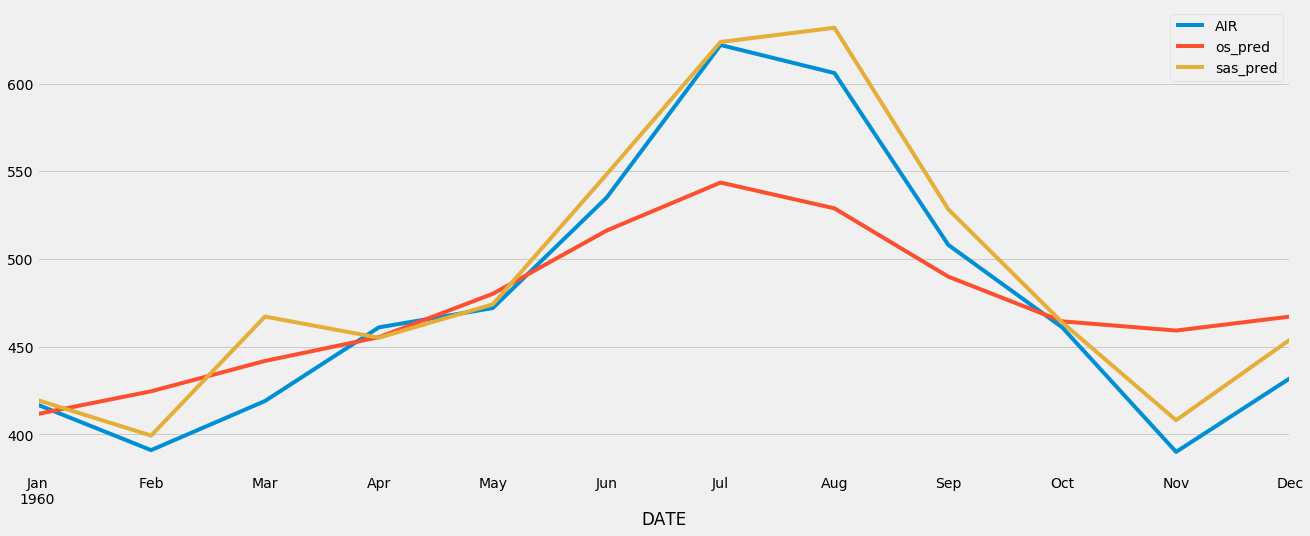

In [52]:
plt.style.use('fivethirtyeight')
test.plot(figsize=(20,8));

In [32]:
train_sas = sas.df2sd(train.reset_index(),libref='work',table="air_train")

In [33]:
train_sas

Libref  = work
Table   = air_train
Dsopts  = {}
Results = Pandas

#### Perform a simple log transform

In [34]:
sas.submit(
    """data sagang.air_train;
    set work.air_train;
    xlog = log( air );
    dt = datepart(date);
    format dt monyy.;
    run;"""
)

{'LOG': "\x0c38                                                         The SAS System                            00:14 Tuesday, December 3, 2019\n\n466        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;\n466      ! ods graphics on / outputfmt=png;\nNOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1\n467        \n468        data sagang.air_train;\n469            set work.air_train;\n470            xlog = log( air );\n471            dt = datepart(date);\n472            format dt monyy.;\n473            run;\n\nNOTE: There were 132 observations read from the data set WORK.AIR_TRAIN.\nNOTE: The data set SAGANG.AIR_TRAIN has 132 observations and 4 variables.\nNOTE: DATA statement used (Total process time):\n      real time           0.00 seconds\n      cpu time            0.01 seconds\n      \n\n474        \n475        ods html5 (id=saspy_internal) close;ods listing;\n476        ",
 'LST': ''}

#### Lets now do it the SAS Way. i.e Submit the sas forecast job from the notebook using SASPy

In [35]:
forecast_job= sas.submit(
        """proc arima data=sagang.air_train;
       identify var=xlog(1,12);
       estimate q=(1)(12) noint method=ml;
       forecast id=dt interval=month printall lead=12 out=work.arima_forecast;
    run;  
      """
)
HTML(forecast_job['LOG'])

IF, we did this purely using **SASPy**

In [36]:
ets  = sas.sasets()

In [37]:
sas_arima = ets.arima(data = "sagang.air_train",
          identify= "var=xlog(1,12)",
         estimate = "q=(1)(12) noint method=ml",
         forecast = "id=dt interval=month printall lead=12",
         out = "sagang.arima_forecast")

In [38]:
dir(sas_arima) # Inpect the object

['CHISQAUTO',
 'CORRB',
 'DESCSTATS',
 'FITSTATISTICS',
 'FORECASTS',
 'FORECASTSONLYPLOT',
 'FORECASTSPLOT',
 'LOG',
 'MODELDESCRIPTION',
 'PARAMETERESTIMATES',
 'RESIDUALCORRPANEL',
 'RESIDUALNORMALITYPANEL',
 'RESIDUALPLOT',
 'SERIESCORRPANEL']


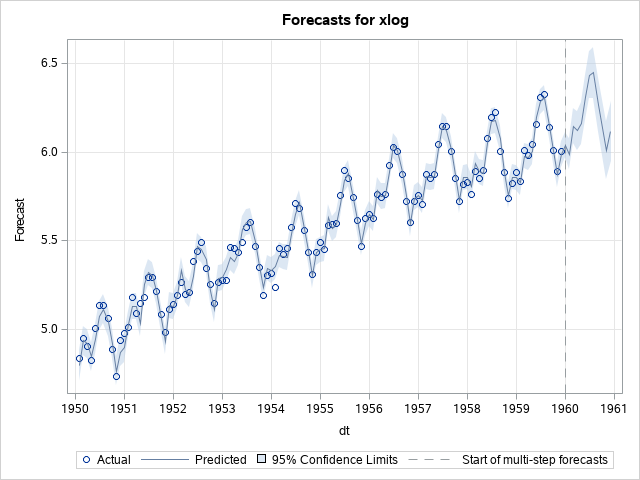

In [39]:
sas_arima.FORECASTSPLOT

In [40]:
rescale = sas.submit("""data sagang.arima_res;
           set work.arima_forecast;
           x        = exp( xlog);
           forecast = exp( forecast + std*std/2 );
           l95      = exp( l95 );
           u95      = exp( u95 );
           run;""")
HTML(rescale['LOG'])

In [41]:
air_output = sas.sasdata(table ='arima_res', libref='sagang')
air_output.tail()

,dt,xlog,FORECAST,STD,L95,U95,RESIDUAL,x
0,1960-08-01,NaN,631.824520,0.072811,546.347280,726.811522,NaN,NaN
1,1960-09-01,NaN,528.293614,0.076603,453.311422,612.076381,NaN,NaN
2,1960-10-01,NaN,463.779115,0.080216,395.033488,540.995865,NaN,NaN
3,1960-11-01,NaN,408.053667,0.083673,345.123172,479.093034,NaN,NaN
4,1960-12-01,NaN,454.010449,0.086993,381.393822,536.378512,NaN,NaN


In [42]:
sas_result = sas.sasdata2dataframe(table ='arima_res', libref='sagang')

In [43]:
sas_result[['FORECAST','STD','L95','U95']].tail()

,FORECAST,STD,L95,U95
139,631.824520,0.072811,546.347280,726.811522
140,528.293614,0.076603,453.311422,612.076381
141,463.779115,0.080216,395.033488,540.995865
142,408.053667,0.083673,345.123172,479.093034
143,454.010449,0.086993,381.393822,536.378512


Tease out just what is needed

In [44]:
# sas_result['sas_pred'] = sas_result['FORECAST']
# sas_result['sas_pred'].loc[sas_result['sas_pred'].isnull()] = sas_result['x']

#Show me results during the hold out period
sas_forecast=sas_result[sas_result['FORECAST'].isnull()==False][-12:]
sas_forecast = sas_forecast.set_index('dt')
sas_forecast.index.freq = 'MS'
sas_forecast.head()

,xlog,FORECAST,STD,L95,U95,RESIDUAL,x
dt,,,,,,,
1960-01-01,NaN,419.604621,0.036539,390.344784,450.455944,NaN,NaN
1960-02-01,NaN,399.298970,0.043609,366.239837,434.515125,NaN,NaN
1960-03-01,NaN,467.154040,0.049682,423.286656,514.296613,NaN,NaN
1960-04-01,NaN,455.095706,0.055090,407.897303,506.216839,NaN,NaN
1960-05-01,NaN,474.116170,0.060013,420.745664,532.335900,NaN,NaN


In [45]:
test['sas_pred'] = sas_forecast['FORECAST']
test

,AIR,os_pred,sas_pred
DATE,,,
1960-01-01,417,411.558005,419.604621
1960-02-01,391,424.549326,399.298970
1960-03-01,419,441.856704,467.154040
1960-04-01,461,455.396801,455.095706
1960-05-01,472,480.122750,474.116170
1960-06-01,535,516.201315,548.259816
1960-07-01,622,543.563421,623.692074
1960-08-01,606,528.854448,631.824520
1960-09-01,508,489.913789,528.293614


In [53]:
from fbprophet import Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


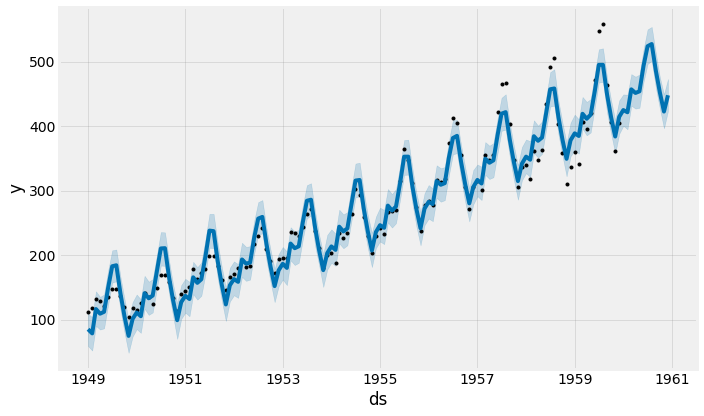

In [60]:
df=train.reset_index().copy()
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])
m = Prophet();
m.fit(df);
future = m.make_future_dataframe(12, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast);

In [66]:
prophet_forecast=forecast[-12:][['ds','yhat']]
prophet_forecast.columns = ['date','prophet_pred']
prophet_forecast=prophet_forecast.set_index('date')
prophet_forecast

,prophet_pred
date,
1960-01-01,424.867297
1960-02-01,421.474389
1960-03-01,456.964802
1960-04-01,451.392919
1960-05-01,453.879051
1960-06-01,493.694875
1960-07-01,523.773060
1960-08-01,527.210227
1960-09-01,486.031158


In [67]:
test['prophet_pred'] = prophet_forecast['prophet_pred']

In [69]:
test

,AIR,os_pred,sas_pred,prophet_pred
DATE,,,,
1960-01-01,417,411.558005,419.604621,424.867297
1960-02-01,391,424.549326,399.298970,421.474389
1960-03-01,419,441.856704,467.154040,456.964802
1960-04-01,461,455.396801,455.095706,451.392919
1960-05-01,472,480.122750,474.116170,453.879051
1960-06-01,535,516.201315,548.259816,493.694875
1960-07-01,622,543.563421,623.692074,523.773060
1960-08-01,606,528.854448,631.824520,527.210227
1960-09-01,508,489.913789,528.293614,486.031158


Plot out the results

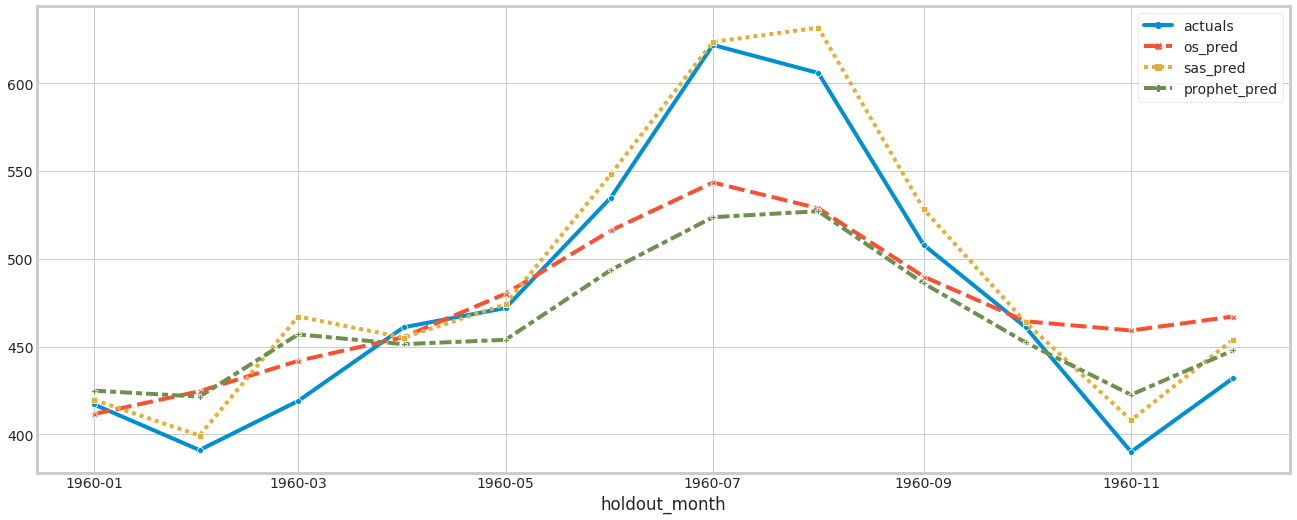

In [130]:
import seaborn as sns

test = test.reset_index()
test.columns =['holdout_month', 'actuals', 'os_pred', 'sas_pred', 'prophet_pred']
test = test.set_index('holdout_month')

f, ax = plt.subplots(figsize=(20, 8))
sns.set_style('whitegrid')
sns.lineplot(data=test,markers=True);


Calculate MAPE

In [118]:
def calc_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

print(f"INFO: MAPE for Keras Simple RNN is {round(calc_mape(test['actuals'],test['os_pred']),2)}%")
print(f"INFO: MAPE for SAS ARIMA is {round(calc_mape(test['actuals'],test['sas_pred']),2)}%")
print(f"INFO: MAPE for ProphetGAM is {round(calc_mape(test['actuals'],test['prophet_pred']),2)}%")

INFO: MAPE for Keras Simple RNN is 6.44%
INFO: MAPE for SAS ARIMA is 3.11%
INFO: MAPE for ProphetGAM is 6.62%
